## Homework
Choose a different dataset (MNIST, FashioMNIST, CIFAR100, ...) and train you own
model by subclassing nn.Module, as I did in notebook 05.

Optional: scramble it and observe if there is a significant change in performance.

For any question, contact me by email.


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
#device config 
device = torch.device('cuda' if torch.cuda.is_available()
                     else 'cpu')

# hyper parameters
input_size = 784 # 28x28
hidden_size = 100
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

In [3]:
# Fashion MNIST

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                          transform=transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                          transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                          shuffle=False)

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!
torch.Size([100, 1, 28, 28]) torch.Size([100])


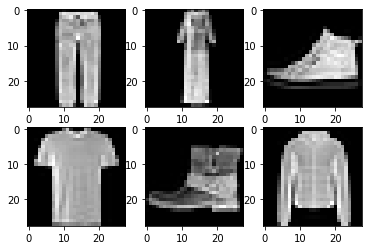

In [4]:
# visualize images 

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(samples[i][0], cmap='gray')

plt.show()

In [5]:
# write NeuralNet class; multiclass problem
# network design: x->linear->relu->linear->softmax->y

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no softmax! CELoss will apply for us
        return out

In [6]:
model = NeuralNet(input_size, hidden_size, num_classes)

# loss and optmizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# training loop
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # reshape 100. 1, 28, 28
        # to  100, 784
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if ((i+1) % 100 == 0):
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')
        
        
# test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        #value, index, don't need first value
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0] # should be 100
        n_correct += (predictions == labels).sum().item()
        
    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}' )

epoch 1 / 2, step 100/600, loss = 0.5565
epoch 1 / 2, step 200/600, loss = 0.6964
epoch 1 / 2, step 300/600, loss = 0.6463
epoch 1 / 2, step 400/600, loss = 0.5260
epoch 1 / 2, step 500/600, loss = 0.3907
epoch 1 / 2, step 600/600, loss = 0.2648
epoch 2 / 2, step 100/600, loss = 0.3582
epoch 2 / 2, step 200/600, loss = 0.4750
epoch 2 / 2, step 300/600, loss = 0.5383
epoch 2 / 2, step 400/600, loss = 0.4697
epoch 2 / 2, step 500/600, loss = 0.3940
epoch 2 / 2, step 600/600, loss = 0.4466
accuracy = 85.41


In [7]:
fashion_class = {0: 'T-shirt/top',
                 1: 'Trouser',
                 2: 'Pullover',
                 3: 'Dress',
                 4: 'Coat',
                 5: 'Sandal',
                 6: 'Shirt',
                 7: 'Sneaker',
                 8: 'Bag',
                 9: 'Ankle boot'
                 }

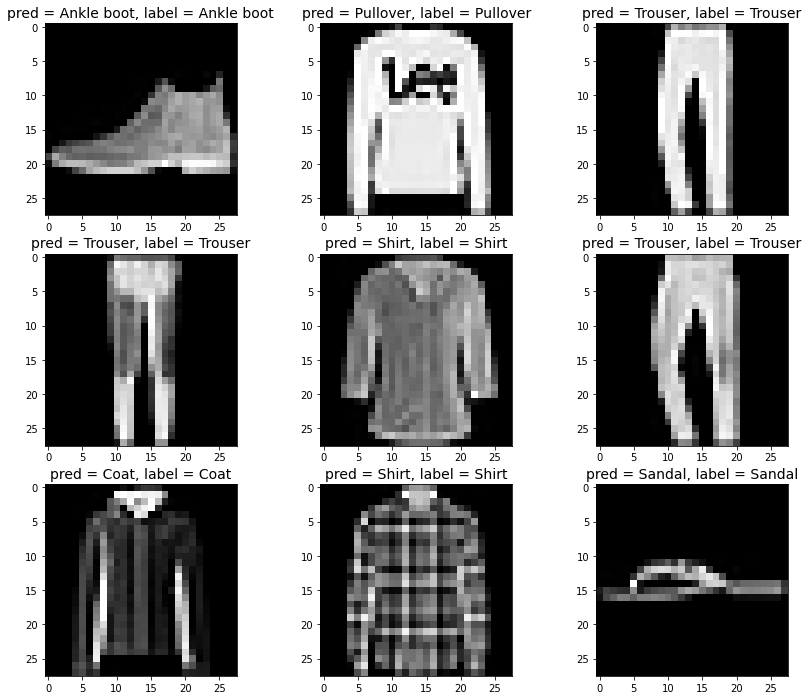

In [8]:
plt.figure(figsize=(14,12))

with torch.no_grad():
  examples = iter(test_loader)
  images, labels = examples.next()
  samples = images
  images = images.reshape(-1, 28*28).to(device)
  labels = labels.to(device)
  output = model(images)
  _, prediction = torch.max(output, 1)
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(samples[i][0], cmap='gray')
    plt.title(f'pred = {fashion_class[prediction[i].item()]}, label = {fashion_class[labels[i].item()]}', fontsize=14)